# Learning Discrete-Time Estimation and Control with Transformers

In [1]:
import numpy as np
import torch
torch.set_default_tensor_type(torch.DoubleTensor)
rng = np.random.default_rng()

myDevice = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from kalman_filter import *
from helpers import *
from plotting import *
from trajectories import *

CUT = 5 # cutoff the first few datapoints because they have too much noise so it is not a fair comparison.
T = 250 # how long to simulate the trajectory # 100

(CVXPY) May 07 10:29:54 AM: Encountered unexpected exception importing solver SCS:
ImportError('dlopen(/Users/sagarasanghavi/.pyenv/versions/3.7.7/lib/python3.7/site-packages/_scs_direct.cpython-37m-darwin.so, 2): Symbol not found: _aligned_alloc\n  Referenced from: /Users/sagarasanghavi/.pyenv/versions/3.7.7/lib/python3.7/site-packages/scs/.dylibs/libgomp.1.dylib (which was built for Mac OS X 10.15)\n  Expected in: /usr/lib/libSystem.B.dylib\n in /Users/sagarasanghavi/.pyenv/versions/3.7.7/lib/python3.7/site-packages/scs/.dylibs/libgomp.1.dylib')


### Define the System Parameters

In [2]:
task_name = 'so2' # Choose from 'so2', 'motion', 'so3', 'accel', 'smd'
A, B, C, Q, R, x0, state_dim, input_dim, obs_dim = sys_params[task_name]

# State Estimation: Continuous State Space 

Dynamical System:

$\vec{x}_{t+1} = A\vec{x}_t + B \vec{u}_t + \vec{w}_t$ is the Transition Model, where $\vec{w}_t \sim \mathcal{N}(\vec{0}, Q)$ is process noise

$\vec{y}_t = C\vec{x}_t + \vec{v}_t$ is Observation Model, where $\vec{v}_t \sim \mathcal{N}(\vec{0}, R)$ is sensor noise

## Generate Trajectories

In [3]:
num_traj = 20 # How many to test on
u_seq = 0.05 * (rng.random(size=(num_traj, T, input_dim))*2 - 1)
traj, meas = generate_traj(num_traj, T, A, B, C, Q, R, x0, u_seq, state_dim, input_dim, obs_dim)
# traj  has shape=(num_traj, T, state_dim)
# meas  has shape=(num_traj, T, obs_dim)
# u_seq has shape=(num_traj, T, input_dim)

Trajectory shape (250, 2)
Measured shape (250, 2)


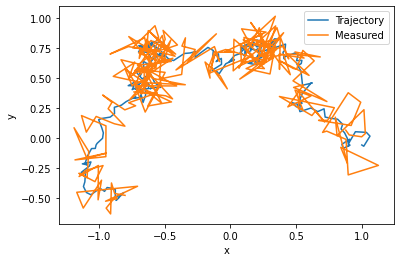

In [4]:
# plot a sample trajectory and noisy measurements
plot({'Trajectory': traj[0], 'Measured': meas[0]})

## 0. Optimization Based Approach using known A, B, C to get best possible fit

This is the baseline for BERT

In [ ]:
err_opt = 0
ls_rec = np.zeros(shape=(num_traj, T, state_dim))

for i in range(num_traj):
    print("Solving problem", i)
    ls_rec[i] = optimal_traj(A, B, C, Q, R, meas[i], x0, u_seq[i])

err_opt += np.linalg.norm(ls_rec - traj)**2 / T / num_traj
    
print("Average Squared Error", err_opt)

## 1. Kalman Filtering using known A, B, C to estimate $\mathbb{E}[X_t | y_1, y_2, ... y_n]$

### 1a. Recalculating gains at each timestep until convergence

In [ ]:
kfiltered = np.zeros(shape=(num_traj, T, state_dim))

for i in range(num_traj):
    kinematics_forward = KFilter(A, B, C, Q, R, state=x0)
    kfiltered[i] = kinematics_forward.simulate(meas[i], u_seq[i])
    
err_fltr = np.linalg.norm(kfiltered - traj)**2 / num_traj / T
    
print("Average Squared Error:", err_fltr)

In [ ]:
plot({'Trajectory': traj[0], 'Measured': meas[0], 'Filtered': kfiltered[0]})

### 1b. Kalman Filter with pure steady state gains

In [ ]:
kfiltered_ss = np.zeros(shape=(num_traj, T, state_dim))

for i in range(num_traj):
    kinematics_forward = KFilter(A, B, C, Q, R, state=x0)
    kinematics_forward.run_till_ss()
    kfiltered_ss[i] = kinematics_forward.simulate(meas[i], u_seq[i])
    
err_fltr_ss = np.linalg.norm(kfiltered_ss - traj)**2 / num_traj / T

print("Average Squared Error", err_fltr_ss)

In [ ]:
plot({'Trajectory': traj[0], 'Measured': meas[0], 'Filtered': kfiltered_ss[0]})

### 1c. Kalman Smoothing with Reverse Kalman Filter

In [ ]:
err_kf_smoothed = 0

for i in range(num_traj):
    kinematics_forward = KFilter(A, B, C, Q, R, state=x0) # Forward KF
    fltr_fwd = kinematics_forward.simulate(meas[i], u_seq[i])
    
    kinematics_backward = KFilter(np.linalg.inv(A), -np.linalg.inv(A) @ B, C, Q, R, state=traj[i][-1]) # Backward KF
    fltr_bkwd = np.flip(kinematics_backward.simulate(np.flip(meas[i], axis=0), np.flip(u_seq[i], axis=0)), axis=0)
    
    # Kalman Smoothed (Avg forward and backward)
    smooth_states = (fltr_fwd + fltr_bkwd) / 2
    err_kf_smoothed += np.linalg.norm(smooth_states - traj[i])**2
    
print("Average Squared Error", err_kf_smoothed / num_traj / T)

## 2. Least Squares System ID + Kalman Filtering

###  2a Update on the identified system at each timestep
The following cell takes about 40 seconds to run.

Note - The System Identification as implemented currently requires the state dimension to match the obs dimension. so2 and so3

In [ ]:
id_filtered = np.zeros(shape=(num_traj, T, state_dim))

for i in range(num_traj):
    # Use the same data as before, but now no peeking on what are the actual A, B matrices
    A_unk, B_unk = np.zeros(shape=(state_dim, state_dim)), np.zeros(shape=(state_dim, input_dim))
    kinematics = KFilter(A_unk, B_unk, C, Q, R, state=x0)
    id_fltr = np.zeros(shape=(T,state_dim))
    
    for t in range(T):
        A_found, B_found = system_id(meas[i], t, x0, u_seq[i])
        kinematics.A = A_found
        kinematics.B = B_found
        kinematics.predict(u_seq[i][t])
        kinematics.update(meas[i][t])
        id_fltr[t] = kinematics.state
    id_filtered[i] = id_fltr
    
err_id_fltr = np.linalg.norm(id_filtered[:, CUT:, :] - traj[:, CUT:, :])**2 / num_traj / T
print("Average Squared Error", err_id_fltr)

In [ ]:
plot({'Trajectory': traj[0], 'Measured': meas[0], 'Filtered': id_filtered[0]})

### 2b Kalman filter for each timestep simulated from the start

The cell below takes about 5 minutes to run.

In [ ]:
err_id_fltr_sim = 0
id_filtered_simulated = np.zeros(shape=(num_traj, T, state_dim))

for i in range(num_traj):
    id_fltr_sim = np.zeros(shape=(T,state_dim))
    for t in range(1, T):
        A_found, B_found = system_id(meas[i], t, x0, u_seq[i])
        kinematics = KFilter(A_found, B_found, C, Q, R, x0)
        id_fltr_sim[t] = kinematics.simulate(meas[i, :t], u_seq[i, :t])[-1]
    id_filtered_simulated[i] = id_fltr_sim
    
err_id_fltr_sim = np.linalg.norm(id_filtered_simulated[:, CUT:, :] - traj[:, CUT:, :])**2 / num_traj / T
print("Average Squared Error", err_id_fltr_sim)

In [ ]:
plot({"Trajectory:": traj[0], "ID + Filtered": id_filtered_simulated[0]})

## 3. Learning a Kalman Filter at each timestep: A and B are unknown

Nonlinear system ID of the Kalman Filter parameters:
$$\tilde{x}_{t+1} = A(I - KC)\tilde{x}_t + B u_t + AKy_t$$
$$\tilde{x}_{t+1} = A'\tilde{x}_t + B' u_t + G'y_t $$ 

where $A' = A(I - KC)$, $B' = B$, $G'= AK$

Observations
$$y_t = C' x_t$$ 

The following cell takes around 20 minutes per trajectory that you want to fit your KF on. In general, it is easiest to just train it on one.

Note that the learning the Kalman Filter can get roughly the same performance as the optimal Kalman Filter if trained for long enough. 

In [ ]:
err_learned_kf = 0
learned_kfs = []
learned_kfs_simulated = np.zeros(shape=(num_traj, T, state_dim))

if True:
    i = 0
# for i in range(num_traj_train, num_traj):
    kinematics = LearnedKFilter(state_dim, input_dim, obs_dim, x0)
    kinematics.fit(meas[i], u_seq[i], eps=2, maxIt=15000)
    learned_kf_sim = kinematics.simulate(meas[i], u_seq[i])
    learned_kfs_simulated[i] = learned_kf_sim
    learned_kfs.append(kinematics)

    plt.figure()
    plt.plot(kinematics.losses[30:])
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.yscale("log")
    plt.xscale("log")
    plt.show()

    err_learned_kf = np.linalg.norm(learned_kf_sim[CUT:, :] - traj[i,CUT:, :])**2

print("Average Squared Error", err_learned_kf / T) #num_traj_test / T)

In [ ]:
learned_kf_sim = kinematics.simulate(meas[i], u_seq[i])
learned_kfs_simulated[i] = learned_kf_sim
learned_kfs.append(kinematics)
plot({'Trajectory': traj[0], "Measured":meas[0], "Optimal KF": kfiltered[0], "Learned KF simulated": learned_kfs_simulated[0]})

In [ ]:
# The cell below is useful to compare the LearnedKF parameters to true parameters of the Kalman Filter
# learned_kf = learned_kfs[0]
# true_kf = KFilter(A, B, C, Q, R, state=x0)
# true_kf.run_till_ss()
# print("Aprime true is", A - A @ true_kf.K @ true_kf.C)
# print("Aprime learned is", learned_kf.Aprime)
# print("Bprime true is", B)
# print("Bprime learned is", learned_kf.Bprime)
# print("Gprime true is", A @ true_kf.K)
# print("Gprime learned is", learned_kf.Gprime)
# print("Cprime true is", C)
# print("Cprime learned is", learned_kf.Cprime)

## ZOH Baseline 
Quantify the error if we just predict the previous token (identity map) - ie. no learning involved

In [ ]:
error = 0
for i in range(num_traj):
    for t in range(1,T):
        error += np.linalg.norm(meas[i, t] - meas[i, t-1])**2
print("Error is", error / num_traj / T)

# Transformer-based techniques to learn the dynamics and filter the position

In [5]:
from transformer import *
from transformer_attention import AttentionQKV
from transformer_attention import MultiHeadProjection
from transformer import PositionEmbedding

embed_dim = 64 # use 64-dimensional embedding for now
batch_size = 32

### Test data

In [6]:
target_sequences_test = torch.from_numpy(meas).to(myDevice)
input_sequences_test = torch.from_numpy(u_seq).to(myDevice)
transformer_input_test = torch.cat((target_sequences_test, input_sequences_test), dim=2)
true_positions_test = torch.from_numpy(traj).to(myDevice)

## GPT-style: Transformer Decoder only for Autoregressive generation

The following cell takes around 15 minutes to run.

In [ ]:
num_iterations = 2000

gpt_model = TransformerDecoder(seq_input_size=(obs_dim+input_dim), embed_size=embed_dim, output_size=obs_dim,
                n_layers=6, n_heads=4, d_filter=256, dropout=None).to(myDevice)
optimizer = torch.optim.Adam(gpt_model.parameters())

losses = []
loss_func = torch.nn.MSELoss(reduction='sum')

for i in range(num_iterations):
    # Generate new training data each iteration
    u_batch = 0.05 * (rng.random(size=(batch_size, T, input_dim))*2 - 1)
    traj_batch, meas_batch = generate_traj(batch_size, T, A, B, C, Q, R, x0, u_batch, state_dim, input_dim, obs_dim)

    # Cast to PyTorch tensors
    target_sequences_train = torch.from_numpy(meas_batch).to(myDevice) # trying to hit noisy data
    input_sequences_train = torch.from_numpy(u_batch).to(myDevice)
    transformer_input_train = torch.cat((target_sequences_train, input_sequences_train), dim=2)
    
    # Run through the GPT model
    decoder_output = gpt_model(transformer_input_train, decoder_mask=None, mask_future=True, shift_target_sequence_right=True)

    # Compute Loss and Backpropagate
    loss = loss_func(decoder_output, target_sequences_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    curr_loss = loss.item()
    losses.append(curr_loss)
    
    print('Iteration', i, ": Loss", curr_loss)

Iteration 0 : Loss 26862.663720437125
Iteration 1 : Loss 69044.39255411486
Iteration 2 : Loss 9350.447375239672
Iteration 3 : Loss 17917.988657194797
Iteration 4 : Loss 23163.14853271998
Iteration 5 : Loss 9647.301783428835
Iteration 6 : Loss 3516.9783044523347
Iteration 7 : Loss 5423.579072419538
Iteration 8 : Loss 8509.500811343056
Iteration 9 : Loss 7502.683633734318
Iteration 10 : Loss 4459.578052088909
Iteration 11 : Loss 2722.613178629851
Iteration 12 : Loss 2524.984105718828
Iteration 13 : Loss 4425.4491211843815
Iteration 14 : Loss 4416.976846589351
Iteration 15 : Loss 2845.375509538993
Iteration 16 : Loss 1949.8510032606305
Iteration 17 : Loss 2383.1411213427896
Iteration 18 : Loss 3043.476472786693
Iteration 19 : Loss 2796.294252736172
Iteration 20 : Loss 1991.086316876418
Iteration 21 : Loss 1391.19766028263
Iteration 22 : Loss 1125.862473255922
Iteration 23 : Loss 1417.3609603470195
Iteration 24 : Loss 1928.1661318692531
Iteration 25 : Loss 1908.281326586026
Iteration 26 : 

Iteration 212 : Loss 305.41720589593604
Iteration 213 : Loss 326.57908117153397
Iteration 214 : Loss 307.6648820611594
Iteration 215 : Loss 326.37549978057325
Iteration 216 : Loss 300.80287602284534
Iteration 217 : Loss 325.30185580928753
Iteration 218 : Loss 308.6531272685698
Iteration 219 : Loss 306.4750240229265
Iteration 220 : Loss 308.592661456398
Iteration 221 : Loss 307.9372093477109
Iteration 222 : Loss 308.51348490523844
Iteration 223 : Loss 307.6987954594516
Iteration 224 : Loss 312.08282005021147
Iteration 225 : Loss 307.40357227084235
Iteration 226 : Loss 324.3886191287686
Iteration 227 : Loss 306.83203771333683
Iteration 228 : Loss 311.6124771218588
Iteration 229 : Loss 304.52980732944684
Iteration 230 : Loss 306.13472796797015
Iteration 231 : Loss 302.5169991535122
Iteration 232 : Loss 312.1528377827118
Iteration 233 : Loss 316.7232376372971
Iteration 234 : Loss 316.5637252032383
Iteration 235 : Loss 303.2843548657122
Iteration 236 : Loss 306.13318958824163
Iteration 237 

Iteration 421 : Loss 289.9709829140462
Iteration 422 : Loss 298.0935016542637
Iteration 423 : Loss 288.2406417670892
Iteration 424 : Loss 286.15490054604214
Iteration 425 : Loss 290.0428770297518
Iteration 426 : Loss 288.378320910499


In [ ]:
plt.figure()
plt.plot(losses[30:])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.yscale("log")
plt.xscale('log')
plt.show()

In [ ]:
torch.save(gpt_model.state_dict(), 'gpt_checkpoint.pt')

### Test the GPT-style Model

In [ ]:
gpt_transformer_sim = gpt_model(transformer_input_test, decoder_mask=None, mask_future=True, shift_target_sequence_right=True)

# Index that we want to visualize from the test indices
i = 0 # index to visualize (0 through 19)

filtered = gpt_transformer_sim.detach().cpu().numpy()

plot({"Trajectory": traj[i], "Measured": meas[i], "Filtered by GPT": filtered[i], "Optimal KF": kfiltered[i]})

print('Average Squared Error between traj and meas', np.linalg.norm(traj - meas)**2 / num_traj / T)
print('Average Squared Error of filtered vs traj', np.linalg.norm(filtered - traj)**2 / num_traj / T)
print('Average Squared Error between filtered and meas', np.linalg.norm(filtered - meas)**2 / num_traj / T)

## BERT-style: Transformer Encoder only, predict true trajectory from Noisy Measurements

In [ ]:
num_iterations = 500

bert_model = TransformerEncoder(seq_input_size=(obs_dim+input_dim), # size of the input tokens (obs_dim + input_dim)
                embed_size=embed_dim, output_size=state_dim, # trying to hit the actual state (not the observation)
                n_layers=6, n_heads=4, d_filter=256, dropout=None).to(myDevice)

optimizer = torch.optim.Adam(bert_model.parameters())

losses = []
loss_func = torch.nn.MSELoss(reduction='sum')

for i in range(num_iterations):
    
    # Generate new training data each iteration
    u_batch = 0.05 * (rng.random(size=(batch_size, T, input_dim))*2 - 1)
    traj_batch, meas_batch = generate_traj(batch_size, T, A, B, C, Q, R, x0, u_batch, state_dim, input_dim, obs_dim)

    # Cast to PyTorch tensors
    meas_sequences_train = torch.from_numpy(meas_batch).to(myDevice)
    input_sequences_train = torch.from_numpy(u_batch).to(myDevice)
    transformer_input_train = torch.cat((meas_sequences_train, input_sequences_train), dim=2) # shape [batch_size, seq_len, (obs_dim+input_dim)]
    true_positions_train = torch.from_numpy(traj_batch).to(myDevice)

    # Run through the model
    encoder_output = bert_model(transformer_input_train, encoder_mask=None)    
    
    # Loss 
    loss = loss_func(encoder_output, true_positions_train) # Trying to hit true positions
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    curr_loss = loss.item()
    losses.append(curr_loss)
        
    print('Iteration', i, ": Loss", curr_loss)

In [ ]:
plt.figure()
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.yscale("log")
plt.xscale("log")

plt.show()

In [ ]:
torch.save(bert_model.state_dict(), 'bert_checkpoint.pt')

### Test the BERT-style Model

In [ ]:
bert_transformer_sim = bert_model(transformer_input_test, encoder_mask=None)

# Index that we want to visualize from the test indices
i = 0

filtered = bert_transformer_sim.detach().cpu().numpy()

plot({"Trajectory": traj[i], "Measured":meas[i], "Filtered":filtered[i], "Optimal KF":kfiltered[i]})

print('Error between traj and meas', np.linalg.norm(traj - meas)**2 / num_traj / T)
print('Average Squared Error of BERT', np.linalg.norm(filtered - traj)**2 / num_traj / T)
print('Error between filtered and meas', np.linalg.norm(filtered - meas)**2 / num_traj / T)